In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:

from bliss.datasets.pair_sim import generate_pair_dataset

from bliss.datasets.lsst import prepare_final_galaxy_catalog, get_default_lsst_psf
from bliss.reporting import get_residual_measurements, get_deblended_reconstructions

import matplotlib.pyplot as plt
from bliss.catalog import FullCatalog, TileCatalog, turn_samples_into_catalogs
import pytorch_lightning as pl

import torch
import numpy as np 

from tqdm import tqdm

# Intro

In [ ]:
pl.seed_everything(42)

Seed set to 42


42

In [ ]:
cat = prepare_final_galaxy_catalog()
psf = get_default_lsst_psf()

In [ ]:
_high_mag_cat = cat[cat['i_ab'] < 25.3]
len(_high_mag_cat)

195552

In [ ]:
ds = generate_pair_dataset(1000, _high_mag_cat, psf)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:07<00:00, 140.89it/s]


In [ ]:
ds['images'].shape

torch.Size([1000, 1, 73, 73])

In [ ]:
ds['centered_sources'].shape

torch.Size([1000, 2, 1, 73, 73])

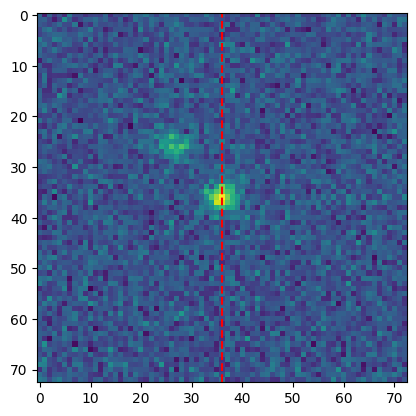

In [ ]:
plt.imshow(ds['images'][0,0])
plt.axvline(73//2, color='r', linestyle='--')

In [ ]:
# plt.imshow(ds['galaxy1'][0,0, 20:-20, 20:-20])
# plt.axvline(33//2, color='r', linestyle='--')

In [ ]:
from bliss.reporting import get_blendedness
from einops import rearrange
im1 = ds['uncentered_sources']
im2 = ds['uncentered_sources'].sum(dim=1)
bld = get_blendedness(im1, im2)

In [ ]:
im1.shape

torch.Size([1000, 2, 1, 73, 73])

In [ ]:
bld.shape

torch.Size([1000, 2])

tensor(2.6538)

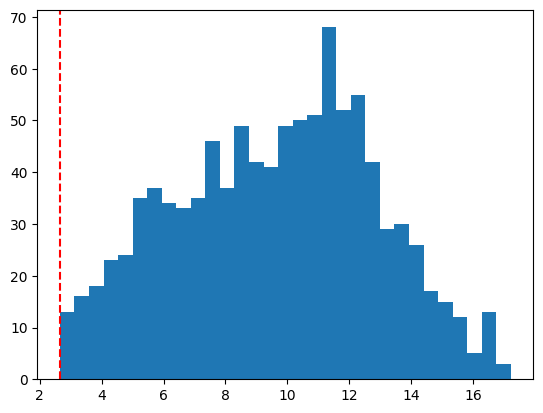

In [ ]:
plt.hist(ds['offsets'].pow(2).sum(1).sqrt().numpy(), bins=31)
plt.axvline(ds['offsets'].pow(2).sum(1).sqrt().min(), color='red', linestyle='--')
ds['offsets'].pow(2).sum(1).sqrt().min()

tensor(2.6538)

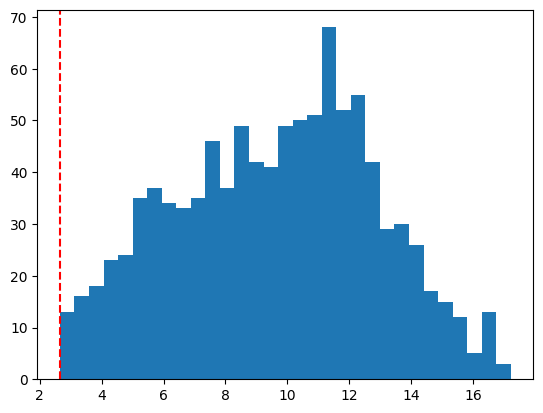

In [ ]:
plocs1 = ds['plocs'][:, 0, :]
plocs2 = ds['plocs'][:, 1, :]
diff_plocs = plocs1 - plocs2
plt.hist(diff_plocs.pow(2).sum(1).sqrt().numpy(), bins=31)
plt.axvline(diff_plocs.pow(2).sum(1).sqrt().min(), color='red', linestyle='--')
diff_plocs.pow(2).sum(1).sqrt().min()

(array([792., 121.,  55.,  22.,   7.,   2.,   0.,   0.,   0.,   1.]),
 array([2.11119652e-04, 9.77763310e-02, 1.95341542e-01, 2.92906761e-01,
        3.90471965e-01, 4.88037169e-01, 5.85602403e-01, 6.83167577e-01,
        7.80732810e-01, 8.78298044e-01, 9.75863218e-01]),
 <BarContainer object of 10 artists>)

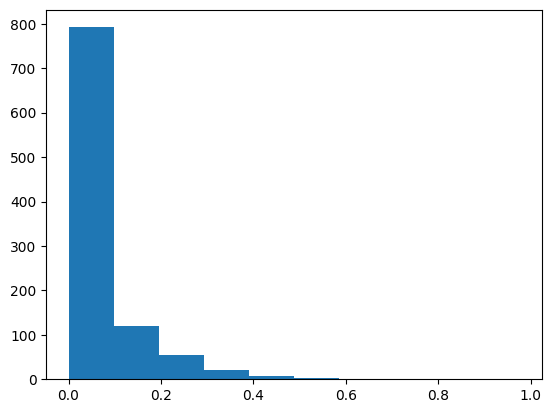

In [ ]:
plt.hist(bld[:, 0].ravel()) # only of first galaxy

In [ ]:
sum(bld[:, 0].ravel() > 0.1)

tensor(203)

In [ ]:
ds['plocs'].shape

torch.Size([1000, 2, 2])

In [ ]:
full_cat = FullCatalog(25, 25, {'n_sources': ds['n_sources'], 'plocs': ds['plocs'], 'galaxy_bools':ds['galaxy_bools']})

In [ ]:
full_cat.plocs.max()

tensor(24.9887)

In [ ]:
true_meas= get_residual_measurements(full_cat, 
                                ds['images'], 
                                paddings=torch.zeros_like(ds['images']),
                                sources=ds['uncentered_sources'])

In [ ]:
full_cat.plocs[:, 0, :]

tensor([[12.5000, 12.5000],
        [12.5000, 12.5000],
        [12.5000, 12.5000],
        ...,
        [12.5000, 12.5000],
        [12.5000, 12.5000],
        [12.5000, 12.5000]])

In [ ]:
meas['snr'].shape

NameError: name 'meas' is not defined

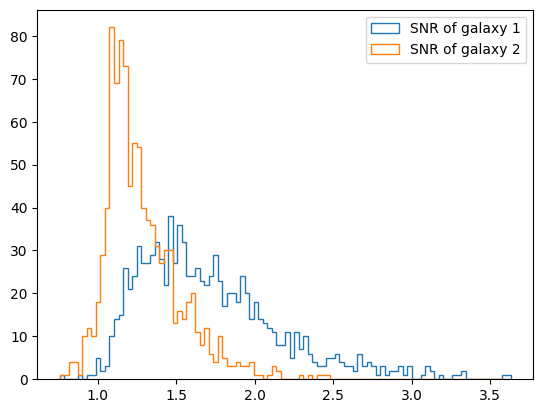

In [ ]:
_, bins, _ = plt.hist(meas['snr'][:, 0, 0].ravel().log10(), bins=100, color='C0', histtype='step', label='SNR of galaxy 1')
plt.hist(meas['snr'][:, 1, 0].ravel().log10(), bins=bins, color='C1', histtype='step', label='SNR of galaxy 2')
plt.legend()

In [ ]:
# plt.imshow(ds['galaxy2'][8,0])
# plt.colorbar()

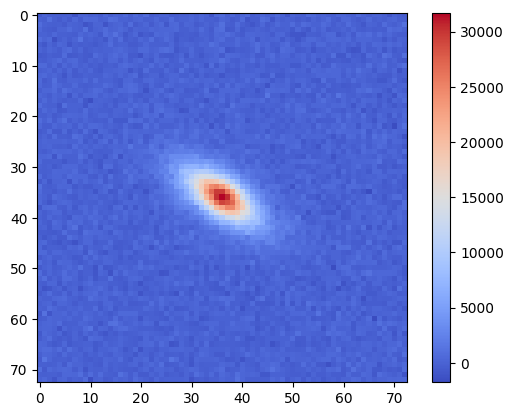

In [ ]:
images = ds['images']
plt.imshow(images[7][0], cmap='coolwarm')
plt.colorbar()

# Check one PDF of fluxes

In [ ]:
mask = bld[:, 0] > 0.1
np.argwhere(mask)[0]

tensor([ 10,  19,  24,  25,  30,  37,  49,  51,  55,  57,  59,  64,  72,  76,
         87,  92,  96, 100, 104, 115, 116, 123, 124, 130, 138, 141, 152, 157,
        165, 167, 169, 180, 185, 186, 195, 198, 201, 206, 211, 212, 214, 223,
        235, 236, 237, 242, 245, 259, 263, 268, 287, 288, 291, 296, 303, 311,
        312, 313, 316, 323, 326, 328, 330, 331, 333, 334, 335, 336, 342, 349,
        365, 367, 369, 371, 381, 399, 404, 405, 406, 410, 413, 415, 422, 428,
        431, 432, 434, 438, 443, 448, 451, 458, 459, 460, 461, 467, 485, 487,
        488, 491, 499, 500, 503, 505, 509, 511, 512, 513, 517, 520, 523, 530,
        532, 537, 543, 545, 547, 553, 565, 569, 592, 597, 608, 611, 620, 622,
        626, 631, 638, 641, 646, 648, 659, 660, 661, 664, 665, 669, 670, 674,
        679, 687, 693, 703, 720, 723, 726, 747, 752, 768, 773, 786, 787, 788,
        790, 798, 805, 810, 818, 819, 822, 823, 827, 829, 832, 835, 847, 851,
        856, 859, 869, 871, 875, 878, 885, 888, 900, 903, 906, 9

In [ ]:
idx = 123
bld[idx]


tensor([0.2747, 0.5562])

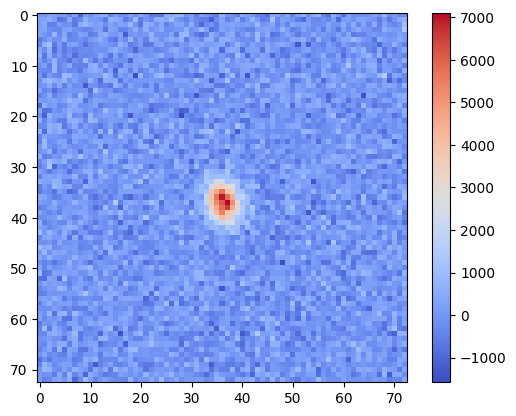

In [ ]:
images = ds['images']
plt.imshow(images[idx][0], cmap='coolwarm')
plt.colorbar()

In [ ]:
from bliss.encoders.detection import DetectionEncoder
device= torch.device("cpu")
detection = DetectionEncoder().to(device).eval()
_ = detection.load_state_dict(
    torch.load(f"../../models/detection_23_23.pt", map_location=device, weights_only=True)
)
detection = detection.requires_grad_(False).eval()

In [ ]:
# now use deblender to obtain reconstructions  and corresponding aperture photometry (for each sample!)
from bliss.encoders.deblend import GalaxyEncoder
deblend_fpath = "../../models/deblender_23_22.pt"
ae_fpath = "../../models/autoencoder_42_42.pt"

deblender = GalaxyEncoder(ae_fpath)
deblender.load_state_dict(torch.load(deblend_fpath, map_location=device, weights_only=True))
deblender = deblender.requires_grad_(False).to(device).eval()

In [ ]:
_images = images[idx, None]
_images.shape

torch.Size([1, 1, 73, 73])

In [ ]:
nt, _, _ = detection.forward(_images.to(device))
nt, nt.shape

(tensor([0.0157, 0.0258, 0.0321, 0.0031, 0.0028, 0.0059, 0.0036, 0.0184, 0.0020,
         0.0027, 0.0121, 0.0041, 0.9960, 0.0049, 0.0014, 0.2300, 0.0050, 0.0224,
         0.0108, 0.0021, 0.0063, 0.0028, 0.0018, 0.0032, 0.0028]),
 torch.Size([25]))

In [ ]:
n_samples = 1000
samples = detection.sample(_images.to(device), n_samples=n_samples)
samples = {k:v.to('cpu') for k,v in samples.items()}

In [ ]:
samples['locs'].shape

torch.Size([1000, 25, 2])

tensor([0.])


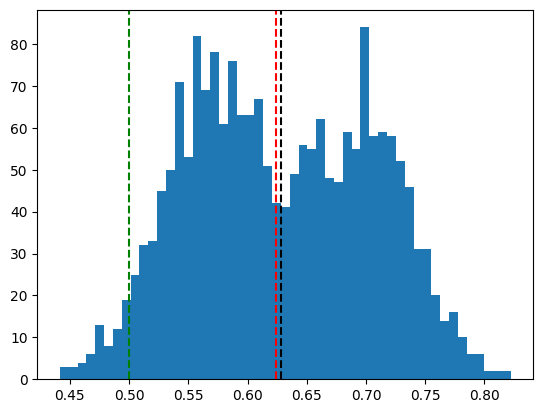

In [ ]:
# how many fall out of the tile
_locs = samples['locs'][:, 25//2, :].flatten()
nonzero_locs = _locs[_locs.nonzero()]

_ = plt.hist(nonzero_locs, bins=51)


total_out = sum(nonzero_locs < 0) + sum(nonzero_locs > 1)
print(total_out / len(nonzero_locs)) # ~ 5%
plt.axvline(nonzero_locs.median(), color='red', linestyle='--')
plt.axvline(nonzero_locs.mean(), color='k', linestyle='--')
plt.axvline(0.5, color='green', linestyle='--')

In [ ]:
samples['n_sources'].sum(axis=1)[:100]

tensor([2., 1., 1., 1., 1., 2., 1., 2., 1., 2., 1., 2., 1., 2., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 2., 2., 1., 2., 1., 2., 2., 2., 1., 2., 1., 1.,
        1., 2., 1., 1., 1., 2., 1., 1., 1., 1., 2., 1., 2., 2., 1., 1., 1., 2.,
        3., 1., 2., 1., 1., 2., 1., 2., 1., 2., 1., 2., 2., 1., 1., 2., 2., 1.,
        2., 1., 1., 1., 1., 1., 1., 2., 1., 2., 1., 2., 1., 2., 1., 1., 1., 1.,
        1., 2., 3., 1., 1., 2., 1., 1., 1., 1.])

In [ ]:
tile_cats = turn_samples_into_catalogs(samples,tile_slen=5, nth=5, ntw=5)

In [ ]:
tile_cats[41].n_sources

tensor([[[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0],
         [1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]]])

In [ ]:
tile_cats[0].n_sources.shape

torch.Size([1, 5, 5])

In [ ]:
# add galaxy params to each catalog 
for ii in tqdm(range(len(tile_cats))):
    tile_cats[ii]['galaxy_bools'] = rearrange(tile_cats[ii].n_sources, 'n nth ntw-> n nth ntw 1').float()
    galaxy_params = deblender.to('cpu').variational_mode(_images, tile_cats[ii].locs)
    galaxy_params *= tile_cats[ii]['galaxy_bools']
    tile_cats[ii]['galaxy_params'] = galaxy_params


100%|██████████| 1000/1000 [00:03<00:00, 310.20it/s]


In [ ]:
sample_cats = []
for ii in range(len(tile_cats)):
    sample_cats.append(tile_cats[ii].to_full_params())

In [ ]:
# get reconstructions for each sample
reconstructions = []
for ii in tqdm(range(len(sample_cats))):
    recon_uncentered = get_deblended_reconstructions(
        sample_cats[ii],
        deblender._dec.to('cpu'),
        slen=25,
        device=torch.device('cpu'),
    )
    reconstructions.append(recon_uncentered)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:05<00:00, 179.34it/s]


In [ ]:
residual_meas = []
for ii in tqdm(range(len(sample_cats))):
    meas = get_residual_measurements(
        sample_cats[ii],
        _images,
        paddings=torch.zeros_like(_images),
        sources=reconstructions[ii],
    )
    residual_meas.append(meas)

100%|██████████| 1000/1000 [00:01<00:00, 594.62it/s]


In [ ]:
residual_meas[0]['flux'].shape

torch.Size([1, 2, 1])

In [ ]:
# pick fluxes that are within central tile only (i.e. that match with central galaxy)
fluxes1 = []
for ii in range(len(sample_cats)):
    meas = residual_meas[ii]
    plocs = sample_cats[ii].plocs[0]
    central_plocs = torch.tensor([12.5, 12.5]).reshape(1, 2)
    dist_to_center = torch.norm(plocs - central_plocs, dim=-1)
    indices = torch.argwhere(dist_to_center < 2.5).flatten()
    if len(indices) > 1:
        raise ValueError("More than one source within central tile found.")
    elif len(indices) == 0:
        fluxes1.append(torch.nan)
    else:
        _idx = indices.item()
        fluxes1.append(meas['flux'][:, _idx, 0].item())
fluxes1 = torch.tensor(fluxes1)

    

In [ ]:
meas['flux']

tensor([[[209168.7031]]])

In [ ]:
sum(torch.isnan(fluxes1))

tensor(1)

In [ ]:
# what about map comparison
map_tile_cat = detection.to('cpu').variational_mode(_images)
map_tile_cat['galaxy_bools'] = rearrange(map_tile_cat.n_sources, 'n nth ntw-> n nth ntw 1').float()
map_galaxy_params = deblender.to('cpu').variational_mode(_images, map_tile_cat.locs)
map_tile_cat['galaxy_params'] = map_galaxy_params

map_cat = map_tile_cat.to_full_params()
map_reconstructions = get_deblended_reconstructions(
    map_cat,
    deblender._dec.to('cpu'),
    slen=25,
    device=torch.device('cpu'),
)
map_residual_meas = get_residual_measurements(
    map_cat,
    _images,
    paddings=torch.zeros_like(_images),
    sources=map_reconstructions,
)

map_idx = torch.argwhere(
    torch.norm(map_cat.plocs[0] - torch.tensor([12.5, 12.5]).reshape(1, 2), dim=-1) < 2.5
).flatten()
assert len(map_idx) == 1, "More than one source within central tile found."
map_flux = map_residual_meas['flux'][:, map_idx.item(), 0].item()
print(f"Map flux: {map_flux}")

Map flux: 209816.53125


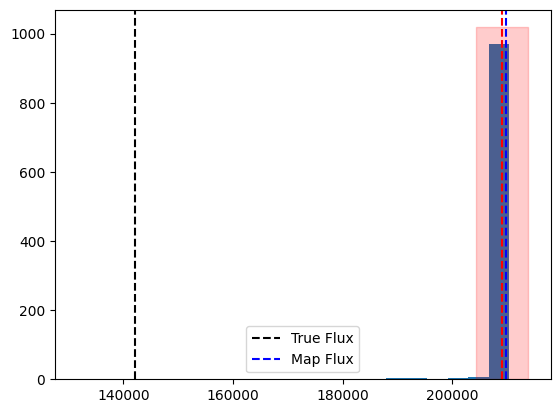

In [ ]:
plt.hist(fluxes1,bins=21)
plt.axvline(fluxes1.nanmean(), color='red', linestyle='--')
plt.axvline(true_meas['flux'][idx, 0, 0].item(), color='k', linestyle='--', label='True Flux')
plt.axvline(map_flux, color='blue', linestyle='--', label='Map Flux')
plt.legend()

# shade error on mean
is_nan = torch.isnan(fluxes1)
std_flux = torch.std(fluxes1[~is_nan])
err = std_flux
# / torch.sqrt(len(fluxes1) - torch.isnan(fluxes1).sum()) * 3
plt.fill_between(
    [fluxes1.nanmean() - err, fluxes1.nanmean() + err],
    0,
    plt.ylim()[1],
    color='red',
    alpha=0.2,
    label='Error on Mean',
)


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0., 694.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 272.,   0.,   0.,   0.,   0.,   0.,   0.,
         31.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([0.        , 0.13333333, 0.26666667, 0.4       , 0.53333333,
        0.66666667, 0.8       , 0.93333333, 1.06666667, 1.2       ,
        1.33333333, 1.46666667, 1.6       , 1.73333333, 1.86666667,
        2.        , 2.13333333, 2.26666667, 2.4       , 2.53333333,
        2.66666667, 2.8       , 2.93333333, 3.06666667, 3.2       ,
        3.33333333, 3.46666667, 3.6       , 3.73333333, 3.86666667,
        4.        ]),
 <BarContainer object of 30 artists>)

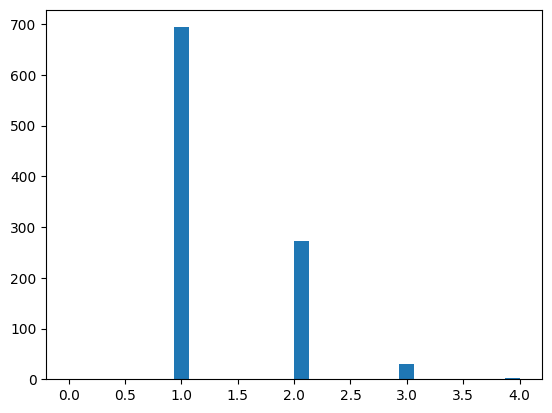

In [ ]:
# n source dist across samples
n_sources = [sample_cat.n_sources.item() for sample_cat in sample_cats]
plt.hist(n_sources, bins=30)

# Samples from script 

In [ ]:
import torch
import matplotlib.pyplot as plt
from bliss.datasets.lsst import APERTURE_BACKGROUND

In [ ]:
ds =torch.load("../../figures/pair_sim/pair_sim_results_2.pt")

In [ ]:
ds.keys()

(dict_keys(['outs', 'bld', 'true_snr', 'true_flux', 'true_plocs', 'images']),
 2000)

In [ ]:
ds['outs'][0].keys()

dict_keys(['nonzero_locs', 'sample_plocs', 'n_sources_samples', 'det_prob', 'sample_fluxes', 'idx', 'n_sources_map', 'map_flux', 'map_plocs'])

In [ ]:
print(len(ds['outs']))

print(ds['bld'].shape)

2000
torch.Size([2000, 2])


(array([ 25.,  42.,  59.,  62.,  76.,  65.,  79.,  92.,  87.,  82.,  95.,
        102.,  93., 112.,  93.,  93., 115., 105., 125.,  84.,  62.,  63.,
         45.,  34.,  29.,  25.,  16.,  18.,  17.,   5.]),
 array([ 2.55690217,  2.81619406,  3.07548594,  3.33477783,  3.59406948,
         3.85336161,  4.11265326,  4.37194538,  4.63123703,  4.89052868,
         5.1498208 ,  5.40911293,  5.66840458,  5.92769623,  6.18698788,
         6.44628   ,  6.70557213,  6.96486378,  7.22415543,  7.48344707,
         7.74273968,  8.00203133,  8.26132298,  8.52061462,  8.77990627,
         9.03919888,  9.29849052,  9.55778217,  9.81707382, 10.07636642,
        10.33565807]),
 <BarContainer object of 30 artists>)

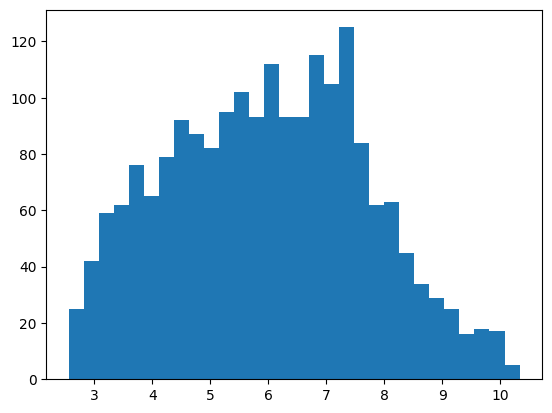

In [ ]:
true_plocs = ds['true_plocs']
dist = torch.norm(true_plocs[:, 0, :] - true_plocs[:, 1, :], dim=-1)
plt.hist(dist.numpy(), bins=30)

(array([208., 227., 204., 190., 174., 134., 118., 129.,  98.,  79.,  74.,
         69.,  57.,  40.,  44.,  37.,  26.,  21.,  19.,  13.,  11.,   5.,
          4.,   4.,   4.,   1.,   5.,   1.,   0.,   1.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([5.89609146e-04, 2.01856345e-02, 3.97816598e-02, 5.93776852e-02,
        7.89737105e-02, 9.85697359e-02, 1.18165761e-01, 1.37761787e-01,
        1.57357812e-01, 1.76953837e-01, 1.96549863e-01, 2.16145888e-01,
        2.35741913e-01, 2.55337954e-01, 2.74933964e-01, 2.94529974e-01,
        3.14126015e-01, 3.33722055e-01, 3.53318065e-01, 3.72914076e-01,
        3.92510116e-01, 4.12106156e-01, 4.31702167e-01, 4.51298177e-01,
        4.70894217e-01, 4.90490258e-01, 5.10086298e-01, 5.29682279e-01,
        5.49278319e-01, 5.68874359e-01, 5.88470340e-01, 6.08066380e-01,
        6.27662420e-01, 6.47258461e-01, 6.66854501e-01, 6.86450481e-01,
        7.

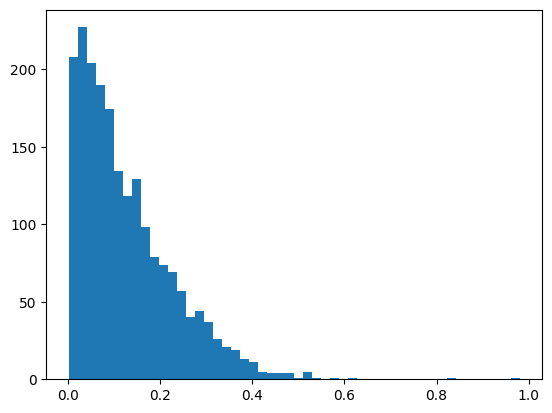

In [ ]:
plt.hist(ds['bld'][:, 0].ravel(), bins=50)

(array([  2.,   0.,   0.,   1.,   1.,   0.,   2.,   0.,   4.,   3.,   2.,
          7.,   9.,   5.,   3.,   5.,  11.,   9.,  14.,  22.,  24.,  17.,
         36.,  39.,  43.,  36.,  45.,  64.,  69.,  76.,  85.,  91., 102.,
        114., 122., 108., 124., 131., 114., 116., 109.,  93.,  65.,  43.,
         18.,  11.,   3.,   0.,   1.,   1.]),
 array([-3.22943568, -3.16501904, -3.10060239, -3.0361855 , -2.97176886,
        -2.90735221, -2.84293556, -2.77851868, -2.71410203, -2.64968538,
        -2.58526874, -2.52085209, -2.4564352 , -2.39201856, -2.32760191,
        -2.26318526, -2.19876862, -2.13435173, -2.06993508, -2.00551844,
        -1.94110167, -1.87668502, -1.81226826, -1.74785161, -1.68343496,
        -1.6190182 , -1.55460155, -1.49018478, -1.42576814, -1.36135137,
        -1.29693472, -1.23251796, -1.16810131, -1.10368466, -1.03926802,
        -0.97485113, -0.91043448, -0.84601784, -0.78160119, -0.71718431,
        -0.65276766, -0.58835101, -0.52393436, -0.45951772, -0.39510083,
 

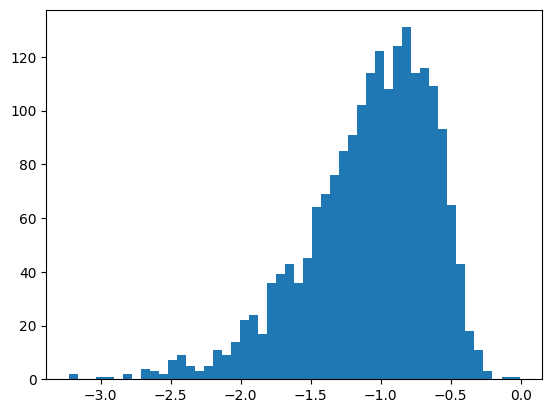

In [ ]:
plt.hist(ds['bld'][:, 0].ravel().log10(), bins=50)

In [ ]:
# need to sort things first!!!!
sorted_indices = [out['idx'] for out in ds['outs']]
true_fluxes = ds['true_flux'][sorted_indices][:, 0, 0]
bld = ds['bld'][sorted_indices][:, 0].ravel()
true_snr = ds['true_snr'][sorted_indices][:, 0, 0]
true_fluxes.shape, bld.shape, true_snr.shape

(torch.Size([2000]), torch.Size([2000]), torch.Size([2000]))

(array([ 25.,  42.,  59.,  62.,  76.,  65.,  79.,  92.,  87.,  82.,  95.,
        102.,  93., 112.,  93.,  93., 115., 105., 125.,  84.,  62.,  63.,
         45.,  34.,  29.,  25.,  16.,  18.,  17.,   5.]),
 array([ 2.55690217,  2.81619406,  3.07548594,  3.33477783,  3.59406948,
         3.85336161,  4.11265326,  4.37194538,  4.63123703,  4.89052868,
         5.1498208 ,  5.40911293,  5.66840458,  5.92769623,  6.18698788,
         6.44628   ,  6.70557213,  6.96486378,  7.22415543,  7.48344707,
         7.74273968,  8.00203133,  8.26132298,  8.52061462,  8.77990627,
         9.03919888,  9.29849052,  9.55778217,  9.81707382, 10.07636642,
        10.33565807]),
 <BarContainer object of 30 artists>)

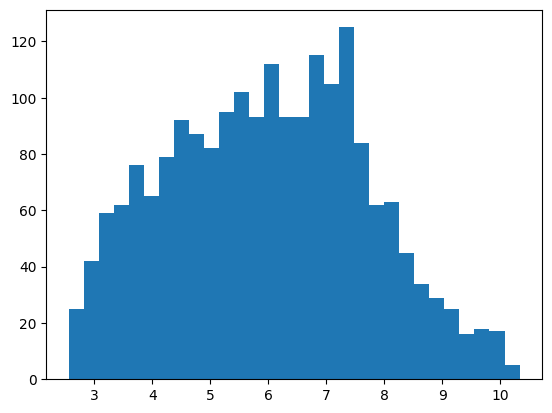

In [ ]:
# distance
true_plocs = ds['true_plocs'][sorted_indices]
dist = torch.norm(true_plocs[:, 0, :] - true_plocs[:, 1, :], dim=-1)
plt.hist(dist.numpy(), bins=30)

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   7.,  10.,
         31.,  85., 124., 142., 161., 174., 155., 148., 128., 116.,  97.,
        106.,  84.,  72.,  62.,  49.,  51.,  31.,  29.,  28.,  16.,  18.,
         12.,  13.,  12.,   2.,  10.,   3.,   5.,   6.,   0.,   1.,   1.,
          2.,   1.,   0.,   0.,   0.,   1.]),
 array([0.15636297, 0.2350544 , 0.31374586, 0.39243728, 0.4711287 ,
        0.54982013, 0.62851161, 0.70720303, 0.78589445, 0.86458588,
        0.9432773 , 1.02196884, 1.1006602 , 1.17935169, 1.25804317,
        1.33673453, 1.41542602, 1.4941175 , 1.57280886, 1.65150034,
        1.73019171, 1.80888319, 1.88757467, 1.96626604, 2.0449574 ,
        2.12364888, 2.20234036, 2.28103185, 2.35972333, 2.43841481,
        2.51710606, 2.59579754, 2.67448902, 2.7531805 , 2.83187199,
        2.91056323, 2.98925471, 3.0679462 , 3.14663768, 3.22532916,
        3.3040204 , 3.38271189, 3.46140337, 3.54009485, 3.61878633,
        3.69747782, 3.77616906, 3.85486054, 3.

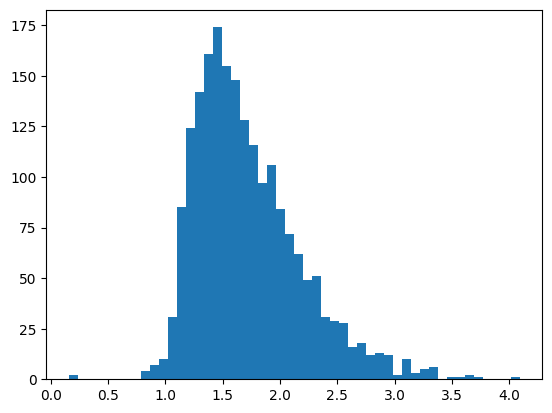

In [ ]:
# snr histogram
plt.hist(ds['true_snr'][:, 0, 0].ravel().log10(), bins=50)

In [ ]:
true_plocs.shape

torch.Size([2000, 2, 2])

In [ ]:
samples_fluxes = torch.stack([out['sample_fluxes'] for out in ds['outs']])
map_fluxes = torch.tensor([out['map_flux'] for out in ds['outs']])

In [ ]:
samples_fluxes.shape, map_fluxes.shape, true_fluxes.shape

(torch.Size([2000, 500]), torch.Size([2000]), torch.Size([2000]))

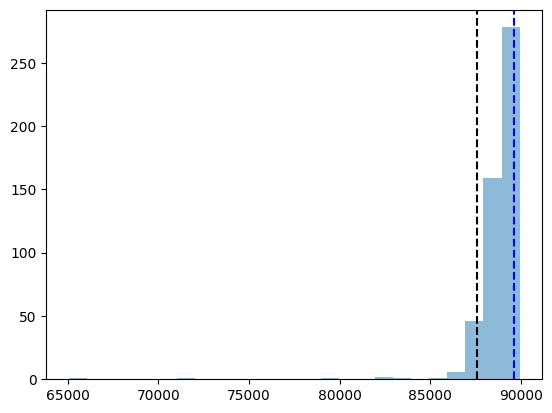

In [ ]:
# check one sample 
idx = 124
plt.hist(samples_fluxes[idx].numpy(), bins=25, alpha=0.5, label='Sample Fluxes')
plt.axvline(true_fluxes[idx].item(), color='k', linestyle='--', label='True Flux')
plt.axvline(map_fluxes[idx].item(), color='blue', linestyle='--', label='Map Flux')

In [ ]:
res1 = (samples_fluxes.nanmean(dim=1) - true_fluxes) / (true_fluxes + APERTURE_BACKGROUND)
res2 = (map_fluxes - true_fluxes) / (true_fluxes + APERTURE_BACKGROUND)
res1.shape, res2.shape

(torch.Size([2000]), torch.Size([2000]))

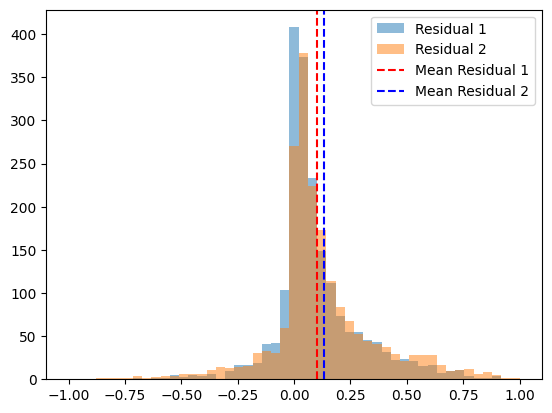

In [ ]:
bins = np.linspace(-1, 1, 50)

_ = plt.hist(res1, bins=bins, alpha=0.5, label='Residual 1')
plt.hist(res2, bins=bins, alpha=0.5, label='Residual 2')
plt.axvline(res1.nanmean().item(), color='red', linestyle='--', label='Mean Residual 1')
plt.axvline(res2.nanmean().item(), color='blue', linestyle='--', label='Mean Residual 2')
plt.legend()

In [ ]:
res1.nanmean(), res2.nanmean()

(tensor(0.1018), tensor(0.1323))

(-1.0, 1.0)

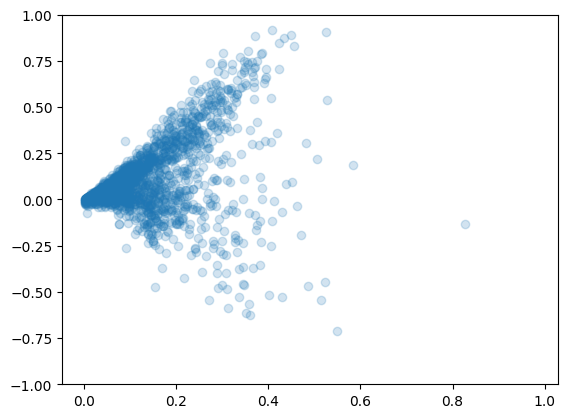

In [ ]:
# as a function of blendedness
plt.scatter(bld, res1, alpha=0.2, label='Residual 1')
# plt.scatter(ds['bld'][:, 0].ravel(), res2, alpha=0.2, label='Residual 2')
plt.ylim(-1, 1)

(-1.0, 1.0)

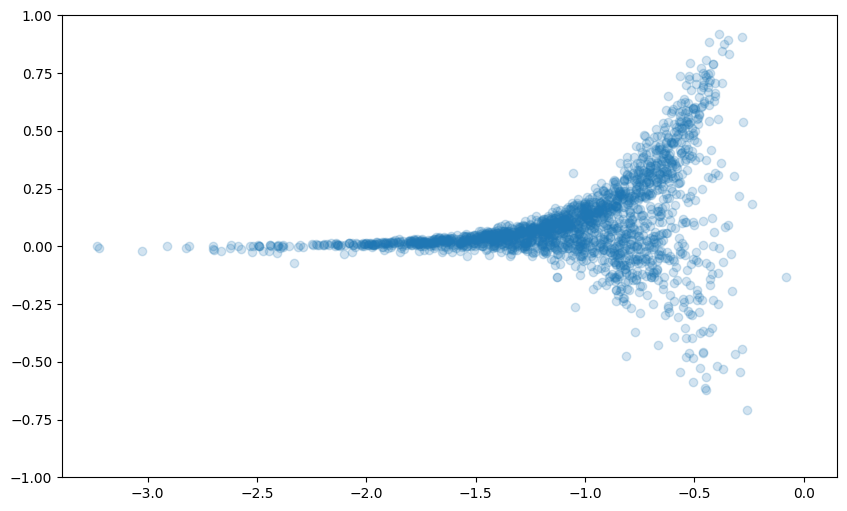

In [ ]:
# as a function of blendedness
plt.figure(figsize=(10, 6))
plt.scatter(bld.log10(), res1, alpha=0.2, label='Residual 1')
# plt.scatter(ds['bld'][:, 0].ravel(), res2, alpha=0.2, label='Residual 2')
plt.ylim(-1, 1)

(-1.0, 1.0)

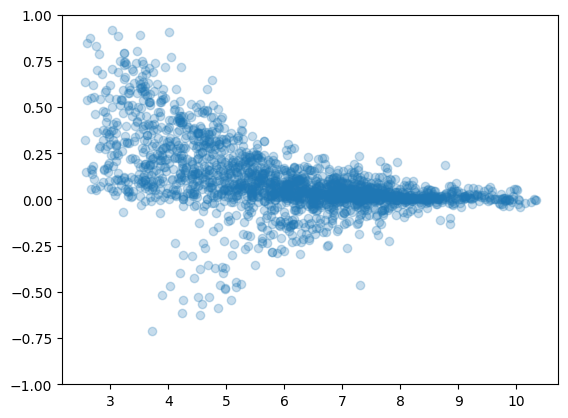

In [ ]:
# as a function of distance
plt.scatter(dist, res1, alpha=0.25, label='Residual 1')
# plt.scatter(dist, res2, alpha=0.25, label='Residual 2')
plt.ylim(-1, 1)

(-1.0, 1.0)

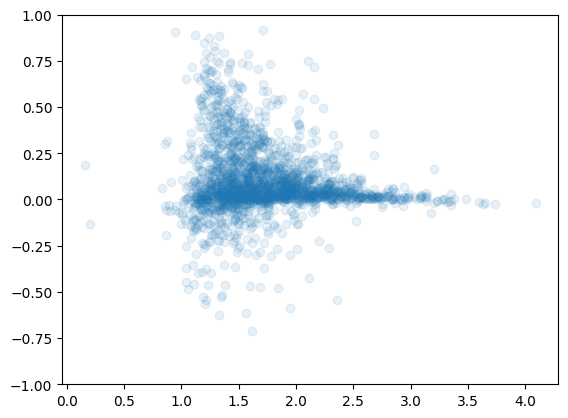

In [ ]:
# snr
plt.scatter(true_snr.log10(), res1, alpha=0.1, label='Residual 1')
plt.ylim(-1, 1)

In [ ]:
# ds['bld'][:, 0].ravel().log10().min()

In [ ]:
bld.shape

torch.Size([2000])

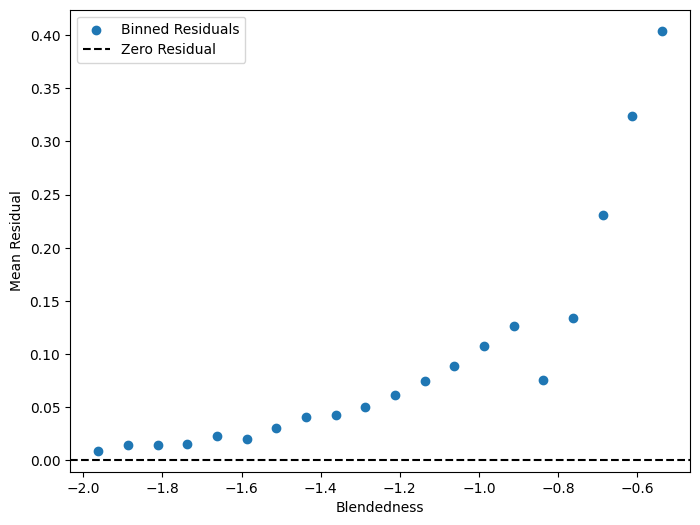

In [ ]:
# binned by blendedness
from scipy.stats import binned_statistic
log_bld = bld.log10()
binned_residuals, bin_edges, _ = binned_statistic(
    log_bld.numpy(),
    res1.numpy(),
    statistic='median',
    bins=20,
    range=(-2, -0.5)
)
plt.figure(figsize=(8, 6))
plt.scatter(
    (bin_edges[:-1] + bin_edges[1:]) / 2,
    binned_residuals,
    label='Binned Residuals',
)
plt.xlabel('Blendedness')
plt.ylabel('Mean Residual')
plt.axhline(0, color='k', linestyle='--', label='Zero Residual')
plt.legend()

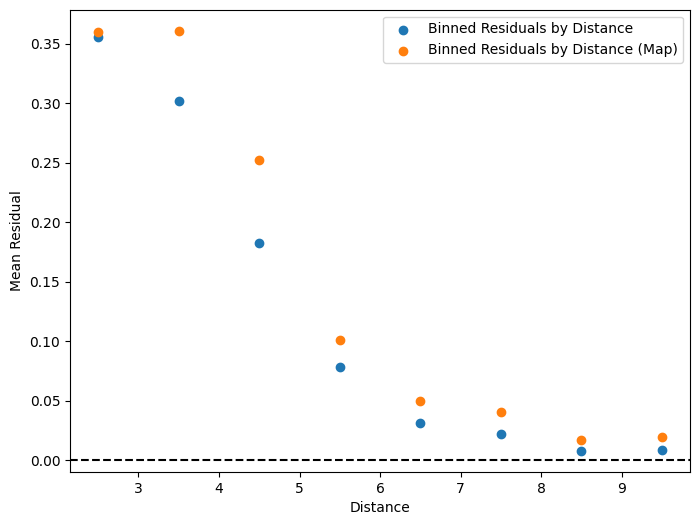

In [ ]:
# now binned by distance
binned_residuals_dist, bin_edges_dist, _ = binned_statistic(
    dist.numpy(),
    res1.numpy(),
    statistic='median',
    bins=10,
    range=(0, 10)
)
# map
binned_residuals_map, bin_edges_map, _ = binned_statistic(
    dist.numpy(),
    res2.numpy(),
    statistic='median',
    bins=10,
    range=(0, 10)
)

plt.figure(figsize=(8, 6))
plt.scatter(
    (bin_edges_dist[:-1] + bin_edges_dist[1:]) / 2,
    binned_residuals_dist,
    label='Binned Residuals by Distance',
    color='C0',
)
plt.scatter(
    (bin_edges_map[:-1] + bin_edges_map[1:]) / 2,
    binned_residuals_map,
    label='Binned Residuals by Distance (Map)',
    color='C1',
)
plt.legend()
plt.xlabel('Distance')
plt.ylabel('Mean Residual')
plt.axhline(0, color='k', linestyle='--', label='Zero Residual')

In [ ]:
true_snr.shape

torch.Size([2000])

In [ ]:
true_snr.min()

tensor(-1.8525)

Text(0, 0.5, 'Mean Residual')

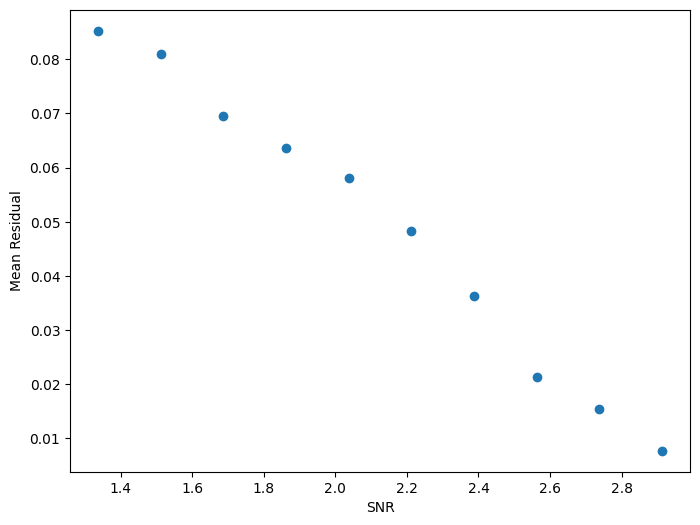

In [ ]:
# bin by snr
mask = ~torch.isnan(true_snr) & (true_snr > 0)
_log_snr = np.log10(true_snr[mask].numpy())
res1_masked = res1[mask].numpy()


binned_residuals_snr, bin_edges_snr, _ = binned_statistic(
    _log_snr,
    res1_masked,
    statistic='median',
    bins=10,
    range=(1.25, 3)
)
plt.figure(figsize=(8, 6))
plt.scatter(
    (bin_edges_snr[:-1] + bin_edges_snr[1:]) / 2,
    binned_residuals_snr,
    label='Binned Residuals by SNR',
)
plt.xlabel('SNR')
plt.ylabel('Mean Residual')

(array([  2.,   0.,   3.,   5.,  17.,  25.,  37.,  69.,  61.,  76.,  83.,
         69., 108., 102.,  98., 112.,  99.,  99., 108., 100.,  96.,  76.,
         84.,  82.,  67.,  55.,  51.,  47.,  30.,  23.,  30.,  18.,  13.,
         11.,   8.,   3.,   9.,   2.,   3.,   3.,   2.,   0.,   2.,   3.,
          3.,   0.,   2.,   0.,   1.,   1.]),
 array([2.89382339, 2.9559443 , 3.01806545, 3.08018637, 3.14230752,
        3.20442843, 3.26654959, 3.3286705 , 3.39079142, 3.45291257,
        3.51503348, 3.57715464, 3.63927555, 3.70139647, 3.76351762,
        3.82563853, 3.88775969, 3.9498806 , 4.01200151, 4.07412243,
        4.13624382, 4.19836473, 4.26048565, 4.32260656, 4.38472748,
        4.44684887, 4.50896978, 4.5710907 , 4.63321209, 4.69533253,
        4.75745392, 4.81957483, 4.88169575, 4.94381714, 5.00593758,
        5.06805897, 5.13017988, 5.1923008 , 5.25442219, 5.31654263,
        5.37866402, 5.44078493, 5.50290585, 5.56502724, 5.62714815,
        5.68926907, 5.75138998, 5.81351089, 5.

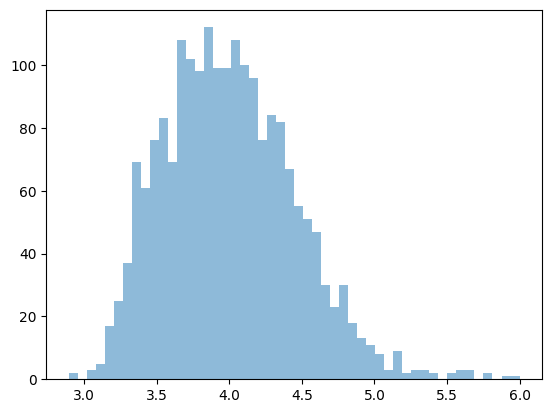

In [ ]:
# histogram standard deviation of samples
stds = [] 
for ii in range(len(samples_fluxes)):
    mask = ~torch.isnan(samples_fluxes[ii])
    if mask.sum() > 1:
        stds.append(torch.std(samples_fluxes[ii][mask]).item())
    else: 
        stds.append(torch.nan)
stds= torch.tensor(stds)
plt.hist(stds.log10(), bins=50, alpha=0.5, label='Standard Deviation of Sample Fluxes')

In [ ]:

samples_fluxes.shape

torch.Size([2000, 500])

Text(0.5, 0, 'Z-score')

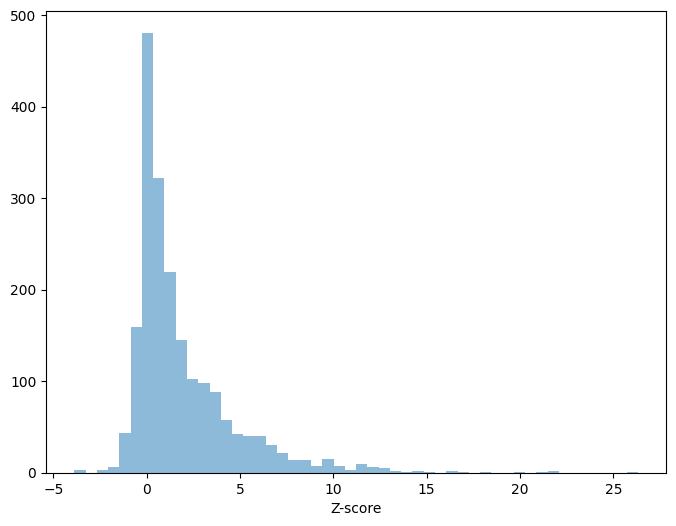

In [ ]:
# now divided by residuals
plt.figure(figsize=(8, 6))
z_score =  (samples_fluxes.nanmean(dim=1) - true_fluxes) / (stds + APERTURE_BACKGROUND)
plt.hist(
    z_score.numpy(),bins=50, alpha=0.5, label='Z-score of Sample Fluxes'
    );
plt.xlabel('Z-score')

Text(0, 0.5, 'Z-score')

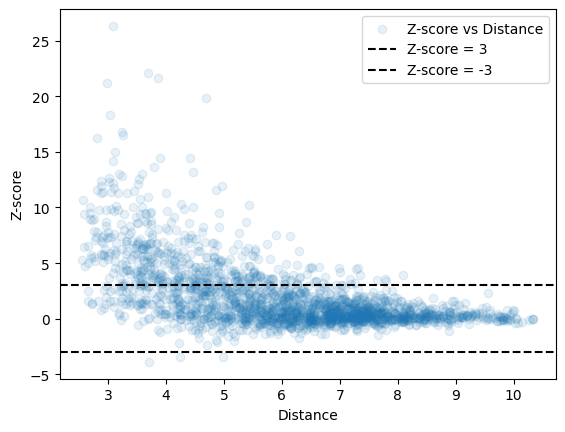

In [ ]:
plt.scatter(dist, z_score.numpy(), alpha=0.1, label='Z-score vs Distance')
plt.axhline(3, color='k', linestyle='--', label='Z-score = 3')
plt.axhline(-3, color='k', linestyle='--', label='Z-score = -3')
plt.legend()
plt.xlabel('Distance')
plt.ylabel('Z-score')

In [ ]:
torch.isnan(z_score).sum()

tensor(2)